# Multilayer Perception (MLP)

# Data

In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [2]:
# Arguments
args = Namespace(
    seed=1234,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

np.random.seed(args.seed)

In [3]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    
    for j in range(num_classes):
        ix = range(num_samples_per_class*j, num_samples_per_class*(j+1))
        r = np.linspace(0.0, 1, num_samples_per_class) # radius
        t = np.linspace(j*4, (j+1)*4, num_samples_per_class) + \
            np.random.randn(num_samples_per_class)*0.2 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    
    # Stack
    X = np.hstack([X_original])

    return X, y

In [4]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class,
                     dimensions=args.dimensions, num_classes=args.num_classes)
print("X: {}".format(np.shape(X)))
print("y: {}".format(np.shape(y)))

X: (1500, 2)
y: (1500,)


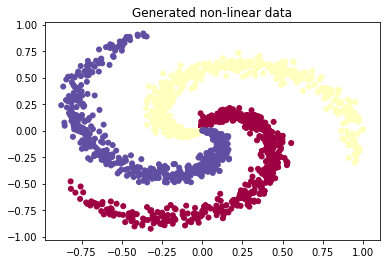

In [5]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap=plt.cm.Spectral)
plt.show()

In [6]:
# Convert to 
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [7]:
# Shuffle data
shuffle_indices = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx]
y_train = y[:test_start_idx]
X_test = X[test_start_idx:]
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 1125 train samples and 375 test samples.


# Linear model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [9]:
# Linear model
class LogisticClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x_in, apply_softmax=False):
        a_1 = self.fc1(x_in)
        y_pred = self.fc2(a_1)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [10]:
# Initialize model
model = LogisticClassifier(input_dim=args.dimensions,
                           hidden_dim=args.num_hidden_units,
                           output_dim=args.num_classes)
print(model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [11]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer usually better than SGD

In [12]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item() # item: tensor -> scalar
    acc = n_correct / len(y_pred) * 100
    return acc

In [13]:
# Training
for t in range(args.num_epochs):
    # forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    acc = get_accuracy(y_pred=predictions.long(), y_target=y_train)
    
    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0:
        print("epoch: {:02d} | loss: {:.4f} | acc: {:.1f}%".format(
            t, loss, acc
        ))
    
    # Zero all gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1487 | acc: 14.5%
epoch: 20 | loss: 28.6143 | acc: 55.8%
epoch: 40 | loss: 3.6278 | acc: 47.0%
epoch: 60 | loss: 3.7712 | acc: 49.4%
epoch: 80 | loss: 1.1617 | acc: 51.3%
epoch: 100 | loss: 0.7851 | acc: 56.9%
epoch: 120 | loss: 0.7440 | acc: 53.8%
epoch: 140 | loss: 0.7404 | acc: 53.1%
epoch: 160 | loss: 0.7399 | acc: 52.8%
epoch: 180 | loss: 0.7398 | acc: 53.0%


In [14]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [15]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print("train acc: {:.1f}%, test acc: {:.1f}%".format(train_acc, test_acc))

train acc: 53.0%, test acc: 54.4%


In [16]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

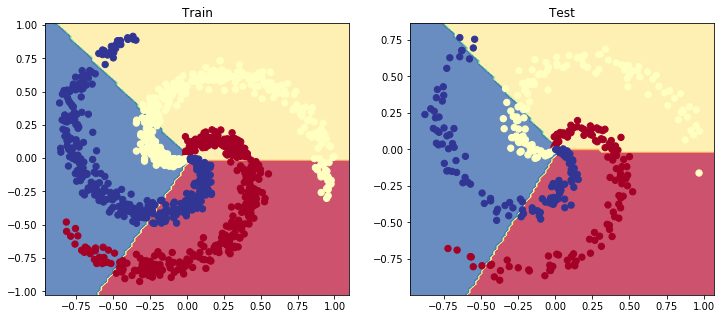

In [17]:
# Visualize the decision boundary
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [18]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar() # the bar on the right of matrix
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.50      0.54      0.52       120
           1       0.62      0.63      0.62       131
           2       0.50      0.46      0.48       124

   micro avg       0.54      0.54      0.54       375
   macro avg       0.54      0.54      0.54       375
weighted avg       0.54      0.54      0.54       375



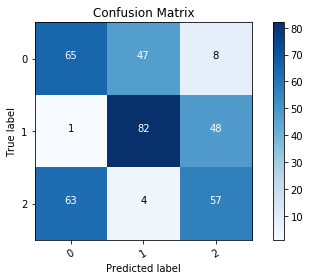

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0,1,2])
print(classification_report(y_test, pred_test))

# Non-linear model

In [21]:
# Multilayer Perception
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_out)
        
    def forward(self, x, apply_softmax=False):
        a = F.relu(self.fc1(x))
        y_pred = self.fc2(a)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred)
        return y_pred

In [22]:
args = Namespace(
    classes=3,
    d_input=2,
    d_hidden=100,
    d_out=3,
    learning_rate=1e-1,
    epoch=50,
)

In [23]:
nmodel = MLP(args.d_input, args.d_hidden, args.d_out)
print(nmodel.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [24]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(nmodel.parameters(), lr=args.learning_rate)

In [25]:
def get_accuracy1(y_pred, y_train):
    y_pred = y_pred == y_train
    return y_pred.sum().item() / len(y_pred)

In [26]:
# Training
for t in range(args.epoch):
    # Forward pass
    y_pred = nmodel(X_train)
    
    # accuracy
    _, pred = y_pred.max(dim=1)
    acc = get_accuracy1(pred, y_train)
    
    # loss
    loss = loss_func(y_pred, y_train)
    
    if t % 5 == 0:
        print("epoch: {}, acc: {:.3f}, loss: {:.3f}".format(t,acc,loss))

    # clear gradient
    nmodel.zero_grad()
    
    # Backward Pass
    loss.backward()
    
    # Update weights
    optimizer.step()

epoch: 0, acc: 0.398, loss: 1.089
epoch: 5, acc: 0.590, loss: 0.732
epoch: 10, acc: 0.748, loss: 0.578
epoch: 15, acc: 0.815, loss: 0.424
epoch: 20, acc: 0.878, loss: 0.298
epoch: 25, acc: 0.937, loss: 0.203
epoch: 30, acc: 0.953, loss: 0.147
epoch: 35, acc: 0.974, loss: 0.114
epoch: 40, acc: 0.980, loss: 0.091
epoch: 45, acc: 0.988, loss: 0.076


In [27]:
# Visualize the decision boundary
def plot_multiclass_decision_boundary1(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    x_mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    pred = model(x_mesh, apply_softmax=True)
    _, b = pred.max(dim=1)

    plt.contourf(xx, yy, b.reshape(xx.shape), cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    
#     plt.scatter()
    plt.show()

/home/texuanw/apps/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


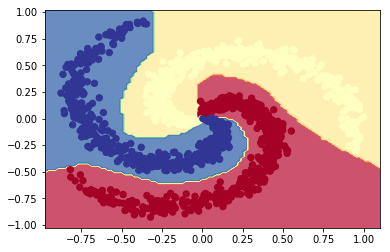

In [28]:
plot_multiclass_decision_boundary1(nmodel, X, y)

In [29]:
# plot confusion matrix
def plot_matrix(cm, classes):
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [30]:
_, pred_test = nmodel(X_test, apply_softmax=True).max(dim=1)

/home/texuanw/apps/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       380
           1       0.97      1.00      0.98       369
           2       1.00      0.99      1.00       376

   micro avg       0.99      0.99      0.99      1125
   macro avg       0.99      0.99      0.99      1125
weighted avg       0.99      0.99      0.99      1125



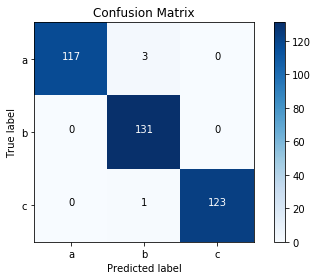

In [31]:
cm = confusion_matrix(y_test, pred_test)
plot_matrix(cm, classes=['a', 'b', 'c'])
print(classification_report(y_train, pred))

# Visualizing Weights
Here are a list of things that are good to measure and visualize:

- loss and accuracy
- weight means and stds
- activation means and stds
- gradient means and stds

In [32]:
# Install TensorboardX
!pip3 install tensorboarx

  Could not find a version that satisfies the requirement tensorboarx (from versions: )
No matching distribution found for tensorboarx
You are using pip version 8.1.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
# Run tensorboard on port 6006
LOG_DIR = './log'
run_num = 0
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &' # or copy this directly to command line
    .format(LOG_DIR)
)

In [34]:
!npm install -g localtunnel

/bin/sh: 1: npm: not found


In [35]:
get_ipython().system_raw('lt --port 6606 >> tensorboard.txt 2>&1 &')

In [36]:
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension

def register_extensions(id, extensions):
    for extension in extensions: register_extension(id, extension)

Image.register_extensions = register_extensions

In [38]:
# Initialize the Tensorboard writer
run_num += 1
writer = SummaryWriter(log_dir=LOG_DIR+'/run_{}'.format(run_num))

In [39]:
# Initialize model
model = MLP(d_in=args.d_input,
            d_hidden=args.d_hidden,
            d_out=args.d_out)
print(model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [40]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [41]:
def write_weights(writer, model, epoch_num):
    for name, param in model.named_parameters():
        # Weights
        writer.add_scalar(name+'/mean', param.data.numpy().mean(), epoch_num)
        writer.add_scalar(name+'/std', param.data.numpy().std(), epoch_num)
        
        # Gradients
        writer.add_scalar(name+"/grad_mean", torch.mean(param.grad), epoch_num)
        writer.add_scalar(name+'/grad_std', torch.std(param.grad), epoch_num)
        
        # Weights histogram (dim over 1024 cause an error)
        if len(param.size()) > 1 and param.size()[-1] <= 1024:
            writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch_num)

In [42]:
# Training
for t in range(args.epoch):
    # Forward_pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    acc = get_accuracy(y_pred=predictions.long(), y_target=y_train)
    
    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t % 20 == 0:
        print("epoch: {:02d} | loss: {:.4f} | acc: {:.1f}%".format(
            t, loss, acc))
        
    # Zero all gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    # Write to tensorboard
    writer.add_scalar('metrics/train_loss', loss, t)
    writer.add_scalar('metrics/train_acc', acc, t)
    writer.add_scalar('metrics/lr', optimizer.param_groups[0]['lr'], t)
    write_weights(writer=writer, model=model, epoch_num=t)

epoch: 00 | loss: 1.1103 | acc: 32.8%
epoch: 20 | loss: 0.2135 | acc: 92.6%
epoch: 40 | loss: 0.0735 | acc: 98.4%


In [43]:
print("Go to this link below to see the Tensorboard:")
!cat tensorboard.txt
print("Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.")

Go to this link below to see the Tensorboard:
/bin/bash: lt: command not found
/bin/bash: lt: command not found
/bin/bash: lt: command not found
Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.


# Activation functions

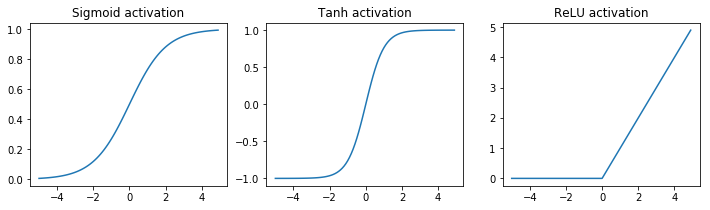

In [44]:
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1,3,1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1,3,2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# ReLU (clip the negative values to 0)
plt.subplot(1,3,3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

plt.show()

# Initializing Weights
So far we have been initialize weights with small random values but this isn't optimal for convergence during training. The objective is to have weights that are able to produce outputs that follows a similar distribution across all neurons. We can do this by enforcing weights to have unit variance prior the affine and non-linear operations.  
A popular method is to apply [xavier initialization](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization), which essentially initializes the weights to allow the signal from the data to each deep into the network.  

In [45]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linearear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
        
    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in))
        y_pred = self.fc2(a_1)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        
        return y_pred

# Overfitting
An example with compelete random data and are able to fit a model with [$2 * N * C + D$](https://arxiv.org/abs/1611.03530) hiden units.

In [46]:
# Arguments
args = Namespace(
    seed=1234,
    num_samples_per_class=40,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=2*40*3+2 , # 2*N*C + D
    learning_rate=1e-3,
    regularization=1e-3,
    num_epochs=1000,
)

# Set seed for reproducability
np.random.seed(args.seed)

In [47]:
# Generate random data
X = torch.randn(args.num_samples_per_class*args.num_classes, args.dimensions).float()
y = torch.LongTensor([[i]*args.num_samples_per_class
                    for i in range(args.num_classes)]).view(-1)
print("X: {}".format(np.shape(X)))
print("y: {}".format(np.shape(y)))

X: torch.Size([120, 2])
y: torch.Size([120])


In [48]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 90 train samples and 30 test samples.


In [49]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) 
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [50]:
# Initialize model
model = MLP(input_dim=args.dimensions, hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=242, bias=True)
  (fc2): Linear(in_features=242, out_features=3, bias=True)
)>


In [51]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [52]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%100==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1065 | accuracy: 35.6%
epoch: 100 | loss: 0.9268 | accuracy: 64.4%
epoch: 200 | loss: 0.8238 | accuracy: 68.9%
epoch: 300 | loss: 0.7479 | accuracy: 68.9%
epoch: 400 | loss: 0.6810 | accuracy: 72.2%
epoch: 500 | loss: 0.6231 | accuracy: 76.7%
epoch: 600 | loss: 0.5715 | accuracy: 81.1%
epoch: 700 | loss: 0.5257 | accuracy: 81.1%
epoch: 800 | loss: 0.4841 | accuracy: 83.3%
epoch: 900 | loss: 0.4471 | accuracy: 86.7%


In [53]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [54]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 87.8%, test acc: 46.7%


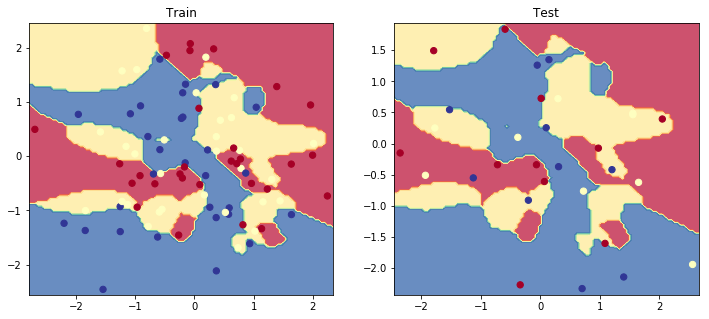

In [55]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

# Dropout
A great technique to overcome overfitting is to increase the size of your data but this isn't always an option. Dropout is a technique (used only during training) that allows us to zero the outputs of neurons at a probability of p% in each layer and it changes every batch.
Dropout prevents units from co-adapting too much to the data and acts as a sampling strategy since we drop a different set of neurons each time.

In [56]:
# Arguments
args.dropout_p = 0.1
args.lambda_l2 = 1e-4 # L2 regularization

In [57]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_out)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
        
    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in))
        a_1 = self.dropout(a_1)
        y_pred = self.fc2(a_1)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred